### Library imports

In [1]:
# Install imblearn to deal with class imbalance
import sys
!{sys.executable} -m pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import time
import random
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC, ADASYN
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler

### Data import

In [3]:
loans = pd.read_csv('./accepted_2007_to_2018Q4.csv')

/scratch/tmp.20499801.bandonov/ipykernel_705467/2434044024.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  loans = pd.read_csv('./accepted_2007_to_2018Q4.csv')


#### Removal of unavailable and unusable features

In [4]:
# These are features that are unavailable at inference time, and cannot be used.
unavailable_features = [
    # 'chargeoff_within_12_mths',
    'collection_recovery_fee',
    # 'dti',
    # 'dti_joint',
    'funded_amnt',
    'funded_amnt_inv',
    'initial_list_status',
    'issue_d',
    'last_credit_pull_d',
    'last_fico_range_high',
    'last_fico_range_low',
    'last_pymnt_amnt',
    'last_pymnt_d',
    'next_pymnt_d',
    'out_prncp',
    'out_prncp_inv',
    'pymnt_plan',
    'recoveries',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp',
    'hardship_flag',
    'hardship_type',
    'hardship_reason',
    'hardship_status',
    'deferral_term',
    'hardship_amount',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'hardship_length',
    'hardship_dpd',
    'hardship_loan_status',
    'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',
]

print(f'Unavailable features: {len(unavailable_features)} / {len(loans.columns)}')

Unavailable features: 42 / 151


In [5]:
# These are features which are available at runtime, but should not be used for inference, either because they introduce bias,
# or because they first have to be converted into a meaningful representation before being able to be used (e.g. loan description)
unused_features = [
    'addr_state',
    'desc',
    'grade',
    'emp_title',
    'id',
    'member_id',
    #    'open_act_il',
    'policy_code',
    'sub_grade',
    'title',
    #    'total_bal_il',
    'url',
    'zip_code',
    #    'sec_app_open_act_il'
]

# TODO: experiment with addr_state and zip_code, leave out (sub_)grade.
print(f'Unused features: {len(unused_features)} / {len(loans.columns)}')

Unused features: 11 / 151


In [6]:
# Drop these two sets of features
features_to_drop = unavailable_features + unused_features
loans = loans.drop(columns=features_to_drop)
print(f'Remaining features: {len(loans.columns)}')

Remaining features: 98


In [7]:
# Extract only the loan defaults and the fully paid loans
defaulted_loans_labels = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']
default_loans = loans[loans['loan_status'].isin(defaulted_loans_labels)]
paid_loans = loans[loans['loan_status'] == 'Fully Paid']

# Join the loan defaults and paid loans. This is now our dataset.
loans = pd.concat([paid_loans, default_loans])

### Data Analysis

In [8]:
# See how loan labels are distributed ('loan_status' is the variable we would like to predict in this task)
status_counts = Counter(loans['loan_status'])
n_loan_defaults = sum([status_counts[label] for label in defaulted_loans_labels])
n_paid_loans = status_counts['Fully Paid']
print(f"Loan defaults: {n_loan_defaults}")
print(f"Fully paid loans: {n_paid_loans}")
print("There is data imbalance!")

Loan defaults: 269360
Fully paid loans: 1076751
There is data imbalance!


In [9]:
individual_loans = loans[loans['application_type'] == 'Individual']
print("Individual loans:", len(individual_loans), ",", round(len(individual_loans) / len(loans), 2))
print("Joint loans:", len(loans) - len(individual_loans), ",", round((len(loans) - len(individual_loans)) / len(loans), 2))

Individual loans: 1320305 , 0.98
Joint loans: 25806 , 0.02


In [10]:
float_cols = loans.select_dtypes(include='float64')
object_cols = loans.select_dtypes(include='object')

print(f'Numerical features: {len(float_cols.columns)}')
print(f'Categorical features: {len(object_cols.columns)}')

possible_values = {}
for col in object_cols.columns:
    possible_values[col] = list(pd.unique(object_cols[col]))

n_na = 0
for key, val in possible_values.items():
    has_na_vals = any(pd.isna(val))
    print(f'{key} -> {val[:10]}, {len(val)}, {has_na_vals}')
    if has_na_vals:
        n_na += 1

print("Number of features with NA:", n_na) 

Numerical features: 87
Categorical features: 11
term -> [' 36 months', ' 60 months'], 2, False
emp_length -> ['10+ years', '3 years', '4 years', '6 years', '8 years', '2 years', '9 years', '< 1 year', '1 year', '5 years'], 12, True
home_ownership -> ['MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE', 'OTHER'], 6, False
verification_status -> ['Not Verified', 'Source Verified', 'Verified'], 3, False
loan_status -> ['Fully Paid', 'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'], 4, False
purpose -> ['debt_consolidation', 'small_business', 'home_improvement', 'major_purchase', 'credit_card', 'other', 'house', 'vacation', 'medical', 'car'], 14, False
earliest_cr_line -> ['Aug-2003', 'Dec-1999', 'Aug-2000', 'Jun-1998', 'Oct-1987', 'Jun-1990', 'Feb-1999', 'Apr-2002', 'Nov-1994', 'Jun-1996'], 740, True
application_type -> ['Individual', 'Joint App'], 2, False
verification_status_joint -> [nan, 'Not Verified', 'Verified', 'Source Verified'], 4, True
sec_app_earliest_cr_l

Let's investigate the distribution of annual_income in our dataset.

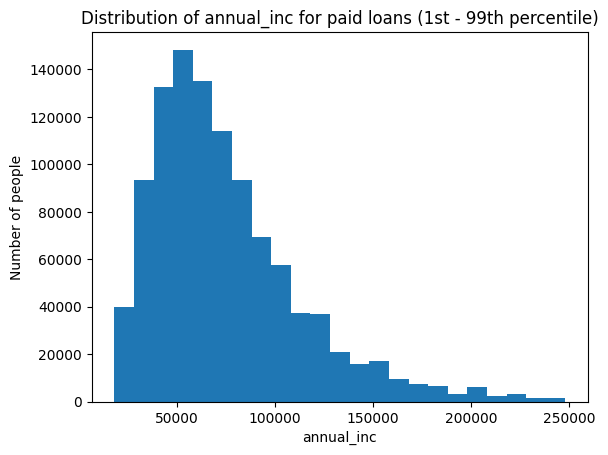

Description
count    1.076751e+06
mean     7.770595e+04
std      7.093496e+04
min      0.000000e+00
25%      4.700000e+04
50%      6.500000e+04
75%      9.300000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64


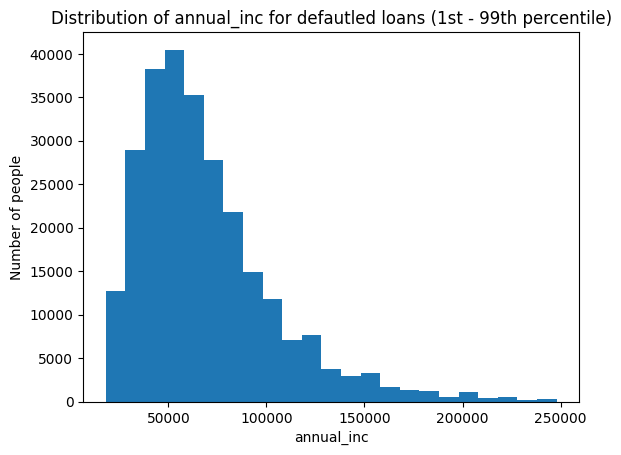

Description
count    2.693600e+05
mean     7.039883e+04
std      6.538521e+04
min      0.000000e+00
25%      4.300000e+04
50%      6.000000e+04
75%      8.500000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64


In [88]:
def plot_distribution(df, attribute, typ, spacing):
    per_1 = int(np.percentile(loans[attribute], 1))
    per_99 = int(np.percentile(loans[attribute], 99))
    bins = range(per_1, per_99, spacing)
    plt.hist(df[attribute], bins=bins)
    plt.title(f'Distribution of {attribute} for {typ} loans (1st - 99th percentile)')
    plt.xlabel(attribute)
    plt.ylabel('Number of people')
    plt.show()

    print("Description")
    print(df[attribute].describe())

plot_distribution(paid_loans, 'annual_inc', 'paid', 10_000)
plot_distribution(default_loans, 'annual_inc', 'defautled', 10_000)

We notice that the annual income of people with loan defaults is slightly lower than the ones with fully paid loans (~ $5000 median difference)

We now plot the requested loan amount per paid loan or loan default 

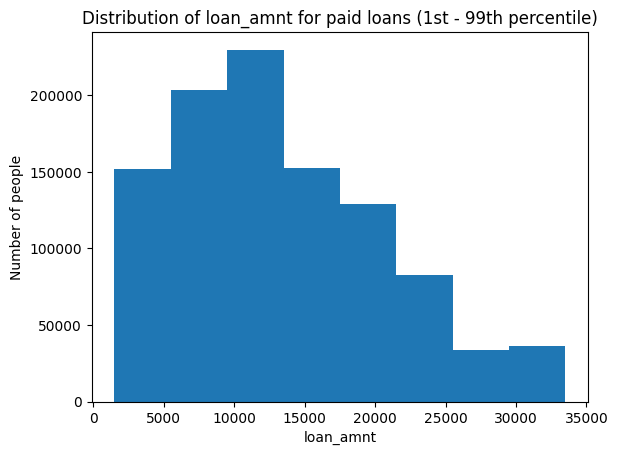

Description
count    1.076751e+06
mean     1.413437e+04
std      8.669029e+03
min      5.000000e+02
25%      7.500000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64


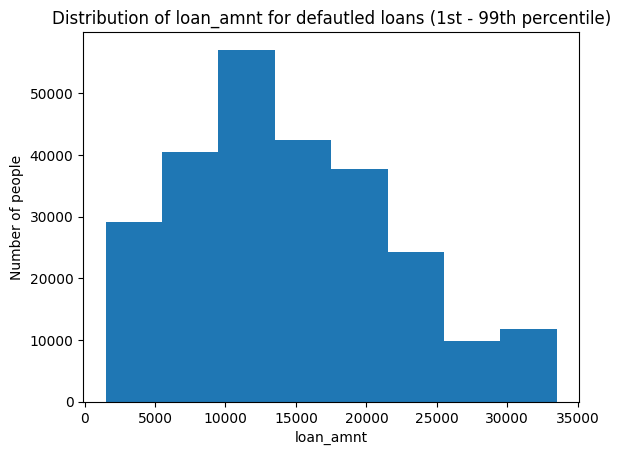

Description
count    269360.000000
mean      15547.816955
std        8814.732243
min         500.000000
25%        9000.000000
50%       14300.000000
75%       20400.000000
max       40000.000000
Name: loan_amnt, dtype: float64


In [89]:
plot_distribution(paid_loans, 'loan_amnt', 'paid', 4000)
plot_distribution(default_loans, 'loan_amnt', 'defautled', 4000)

We can see that people who default their loans request a slightly higher amount (~ $2300 median difference)

Now, let us plot the correlation between these two variables and the corresponding loan labels.

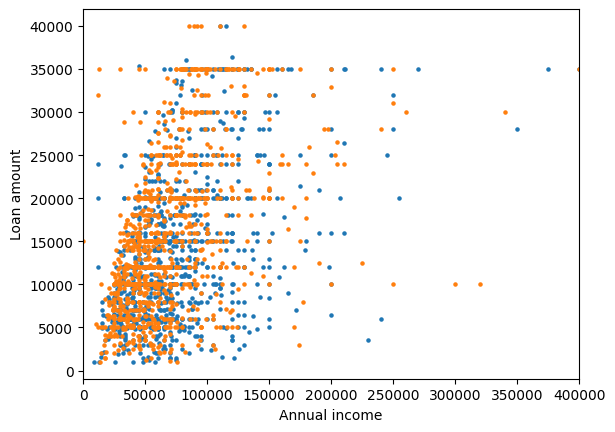

In [134]:
n_samples_each = 1000

paid_loans_sample = paid_loans.sample(n=n_samples_each, random_state=42)
plt.scatter(
    paid_loans_sample['annual_inc'],
    paid_loans_sample['loan_amnt'],
    label='Fully paid',
    s=5
)


default_loans_sample = default_loans.sample(n=n_samples_each, random_state=42)
plt.scatter(
    default_loans_sample['annual_inc'],
    default_loans_sample['loan_amnt'],
    label='Loan default',
    s=5
)

plt.xlabel('Annual income')
plt.ylabel('Loan amount') 
plt.xlim(0, 400_000)
plt.show()

There seems to be positive correlation between the annual income and the requested loan amount both for fully paid loans and ones with default. However, from the plot about, it seems difficult to determine whether a loan will default or not based on these two features alone.

### Data cleaning

#### Convert text features into numerical ones

In [11]:
def get_employment_years(years_string):
        if type(years_string) is not str:
            return years_string
    
        if '<' in years_string:
            return 0
        
        if '10' in years_string:
            return 10
        
        return int(years_string[0])

def convert_text_features_into_numerical_ones(loans_orig: pd.DataFrame, in_place=False):
    loans = loans_orig if in_place else loans_orig.copy()

    # Impute categorical features by using dummy variables
    non_na_categorical_features = [
        'term',
        'home_ownership',
        'verification_status',
        'purpose',
        'disbursement_method',
        'application_type'
    ]

    na_categorical_features = ['verification_status_joint']
    
    dummies_for_non_na_categorical_features = pd.get_dummies(loans[non_na_categorical_features], dtype='float64', drop_first=True)
    dummies_for_na_categorical_features = pd.get_dummies(loans[na_categorical_features], dtype='float64', drop_first=True, dummy_na=True)
    
    loans = pd.concat([
        loans.drop(non_na_categorical_features + na_categorical_features, axis=1),
        dummies_for_non_na_categorical_features,
        dummies_for_na_categorical_features
    ], axis=1)
    
    # Convert dates of the format Mon-Year to just an integer representing the year
    map_datestr_to_year = lambda x: int(x[-4:]) if type(x) is str else x
    loans['earliest_cr_line'] = loans['earliest_cr_line'].map(map_datestr_to_year)
    loans['sec_app_earliest_cr_line'] = loans['sec_app_earliest_cr_line'].map(map_datestr_to_year)

    # Convert the emp_length string to a number representing the number of employment years.
    loans['emp_length'] =  loans['emp_length'].map(get_employment_years)

    # Convert the indicator variable into a numerical one. These are the 2 classes we want to predict
    map_loan_status = lambda x: 1 if x == 'Fully Paid' else 0
    loans['loan_status'] = loans['loan_status'].map(map_loan_status)

    return loans

loans = convert_text_features_into_numerical_ones(loans)

#### Feature imputation

##### Approach 1: Simple imputation. Fast, but not as accurate

In [12]:
def simple_imputer(df):
    simple_imputer = SimpleImputer(strategy='median')
    imputed_df = pd.DataFrame(simple_imputer.fit_transform(df), columns=df.columns)
    return imputed_df, simple_imputer

##### (WIP) Approach 2: More involved imputation by manually selecting how each feature should be imputed.

In [13]:
def involved_imputer(df):
    features = loans.columns
    na_features = [feature for feature in features if any(pd.isna(loans[feature]))]
    print(len(na_features), '/', len(features), na_features)
    for feature in na_features[:10]:
        to_plot = loans[feature].copy()
        plt.hist(to_plot)
        # plt.yscale('log')
        plt.title(feature)
        plt.show()

#### Feature scaling

In [14]:
def simple_scaler(df):
    robust_scaler = RobustScaler()
    scaled_df = pd.DataFrame(robust_scaler.fit_transform(df), columns=df.columns)
    return scaled_df, robust_scaler

#### Extract features and labels

In [15]:
imbalanced_X = loans.loc[:, loans.columns != 'loan_status']
imbalanced_y = loans['loan_status']

#### Deal with class imbalance 

In [16]:
# Some variables used in all of the following approaches
class_sizes = [len(imbalanced_y[imbalanced_y == i])for i in range(2)]
size_difference = abs(class_sizes[0] - class_sizes[1])
minority_class = np.argmin(class_sizes)
majority_class = 1 - minority_class

##### Approach 1: Oversampling the minority class

In [17]:
# 1.1 Duplicate examples from the minority class, until sizes of both classes match
def duplicate_minority_class(X_imbalanced, y_imbalanced):
    index_to_resample = y_imbalanced == minority_class
    upsampled_minority_class = X_imbalanced[index_to_resample].sample(n=size_difference,  replace=True)
    upsampled_minority_labels = y_imbalanced[upsampled_minority_class.index]
    X = pd.concat([X_imbalanced, upsampled_minority_class])
    y = pd.concat([y_imbalanced, upsampled_minority_labels])
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    reshuffled_index = np.random.permutation(X.index)
    X = X.reindex(reshuffled_index)
    y = y.reindex(reshuffled_index)
    return X, y

In [18]:
# 1.2 SMOTE (Create synthetic samples by interpolating between existing minority samples)
# https://arxiv.org/pdf/1106.1813
# Note: This might take several minutes.
def generate_synthetic_datapoints(row_index, neighbor_indices, samples, n_samples):
    s = time.time()
    row = samples.iloc[row_index]
    neighbor_indices = np.random.choice(neighbor_indices, n_samples)
    neighbors = samples.iloc[neighbor_indices]

    generated_samples = []
    for index, neighbor in neighbors.iterrows():
        alpha = random.random()
        new_sample = (1 - alpha) * row + alpha * neighbor

        categorical_choices = np.array([row[categorical_features], neighbor[categorical_features]])
        categorical_indices = np.random.randint(0, 2, size=len(categorical_features))
        new_sample[categorical_features] = categorical_choices[categorical_indices, np.arange(len(categorical_features))]
        generated_samples.append(new_sample)
        
    e = time.time()
    return generated_samples

def smote(X_imbalanced, y_imbalanced, k=5):
    index_to_resample = y_imbalanced == minority_class
    minority_samples = X_imbalanced[index_to_resample]
    
    smote_n = int(np.ceil(size_difference / class_sizes[minority_class]))
    synthetic_samples = []
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    nearest_neighbors.fit(minority_samples)

    neighbor_indices_per_row = nearest_neighbors.kneighbors(minority_samples, n_neighbors=k+1, return_distance=False)

    for neighbor_indices in neighbor_indices_per_row:
        generated_datapoints = generate_synthetic_datapoints(neighbor_indices[0], neighbor_indices[1:], minority_samples, smote_n)
        synthetic_samples.extend(generated_datapoints)

    synthetic_labels = pd.Series([minority_class] * len(synthetic_samples))
    y = pd.concat([y_imbalanced, synthetic_labels])
    synthetic_samples_df = pd.DataFrame(synthetic_samples)
    X = pd.concat([X_imbalanced, synthetic_samples_df])
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    reshuffled_index = np.random.permutation(X.index)
    X = X.reindex(reshuffled_index)
    y = y.reindex(reshuffled_index)
    return X, y

In [19]:
from imblearn.over_sampling import ADASYN

# 1.3 ADASYN (Adaptive synthetic sampling)
# https://ieeexplore.ieee.org/document/4633969
def adasyn_auto(X_imbalanced, y_imbalanced, k=5):
    smote = ADASYN(categorical_features=categorical_features, k_neighbors=nn)
    X, y = smote.fit_resample(imbalanced_X, imbalanced_y)
    return X, y

##### Approach 2: Undersampling the majority class

In [20]:
# 2.1 Random undersampling (Select a random sample of the majority class, such that the sizes of both classes match)
def random_undersampling(X_imbalanced, y_imbalanced):
    index_to_resample = y_imbalanced == majority_class
    undersampled_majority_class = X_imbalanced[index_to_resample].sample(n=class_sizes[majority_class])
    undersampled_majority_labels = y_imbalanced[undersampled_majority_class.index]

    minority_class = X_imbalanced[y_imbalanced == minority_class]
    minority_class_labels = y_imbalanced[y_imbalanced == minority_class]
    
    X = pd.concat([undersampled_majority_class, minority_class])
    y = pd.concat([undersampled_majority_labels, minority_class_labels])
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    reshuffled_index = np.random.permutation(X.index)
    X = X.reindex(reshuffled_index)
    y = y.reindex(reshuffled_index)
    return X, y

In [21]:
# 2.2 Tomek Links
# https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc
def tomek_links_auto(X_imbalanced, y_imbalanced):
    tl = TomekLinks()
    X, y = tl.fit_resample(X_imbalanced, y_imbalanced)
    return X, y

##### Approach 3: Loss function class weighing

In [22]:
# 3.1 Balance the penalties for miscalissification based on class sizes
class_weight = 'balanced'

##### Choosing an approach

In [23]:
def balance_classes(X_imbalanced, y_imbalanced):
    return duplicate_minority_class(X_imbalanced, y_imbalanced)

### Model training and evaluation

In [24]:
def train_eval_model(X_train, y_train, X_test, y_test, model):
    # Impute and scale data
    X_train, imputer = simple_imputer(X_train)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    X_train, scaler = simple_scaler(X_train)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    # Fit model
    model.fit(X_train, y_train)

    # Predict test data
    y_pred = model.predict(X_test)

    # Report metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(accuracy)
    print(conf_matrix)
    print(report)

In [25]:
random_state = 42
X = imbalanced_X
y = imbalanced_y
X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, y_train = balance_classes(X_train_imbalanced, y_train_imbalanced)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(penalty='l2', class_weight=class_weight, solver='liblinear', random_state=random_state),
    'Decision Tree': DecisionTreeClassifier(class_weight=class_weight, random_state=random_state),
    'Random Forest': RandomForestClassifier(class_weight=class_weight, random_state=random_state),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'MLP': MLPClassifier(hidden_layer_sizes=[100, 100], random_state=random_state)
}

for name, model in models.items():
    print(f"Training {name}")
    train_eval_model(X_train, y_train, X_test, y_test, model)
    print()

Training Logistic Regression
